In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
import scipy.stats as ss
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

from arch import arch_model
from scipy.optimize import minimize 
from scipy.stats import t


In [2]:
def qqplot(x, dist="norm"):
    fig, ax = plt.subplots(1,1)
    t, o = ss.probplot(x, dist=dist, plot=ax)
    
    if isinstance(dist, str):
        title = f"{dist.title()} Q-Q Plot"
    else:
        title = f"{dist.dist.name.title()} Q-Q Plot"
        
    
    min_ = min(t[0])
    max_ = max(t[0])
    
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.set_title(title)

    ax.scatter(t[0],t[1])
    ax.plot((min_, min_), (max_,max_))

def plot_acf_graphs(x: pd.Series, title: str):
    fig, axs = plt.subplots(2,1)
    ax1, ax2 = axs

    ax1.set_title(title)
    ax1.set_ylabel(title)
    ax1.plot(x, c='b')

    ax2.set_ylabel('ACF')
    ax2.set_xlabel('Lag')

    sm.graphics.tsa.plot_acf(x, ax=ax2, lags=50, title=None, auto_ylims=True, c='orange')
    


## Part A


## i)

Read in data, compute log returns etc. Plot hist, kde & normal fit

In [3]:
df = pd.read_csv("../data/QRM-2022-cw1-data-a.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['log_returns'] = 100*np.log(1 + df['SX5E'].pct_change())


In [4]:
mean = df['log_returns'].mean()
stdev = df['log_returns'].std()
skew = df['log_returns'].skew()
kurt = df['log_returns'].kurtosis()

print(f"Mean: {mean:.5f}")
print(f"Stdev: {stdev:.5f}")
print(f"Skew: {skew:.5f}")
print(f"Kurtosis: {kurt:.5f}")

Mean: 0.01522
Stdev: 1.24291
Skew: -0.77750
Kurtosis: 10.12650


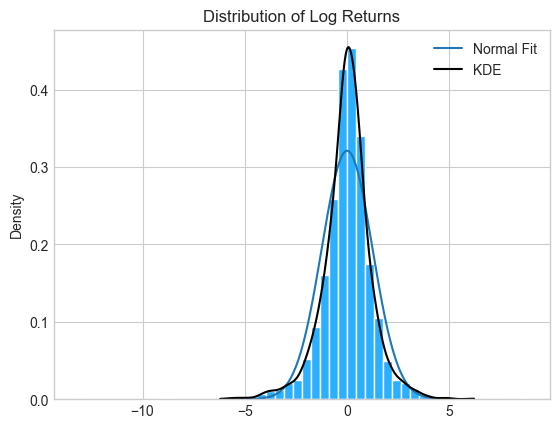

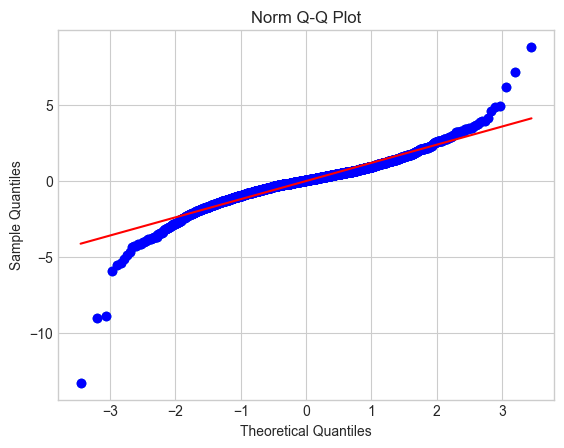

In [5]:

kde = ss.gaussian_kde(df['log_returns'].dropna())
x = np.linspace(mean - 5*stdev, mean + 5*stdev, 1001)

plt.plot(x, ss.norm.pdf(x, mean, stdev), label= 'Normal Fit');
plt.hist(df['log_returns'], bins=50, density=True,facecolor='#2ab0ff', edgecolor='white'); 
plt.plot(x, kde(x), label='KDE', color='k');
plt.title('Distribution of Log Returns')
plt.ylabel('Density')
plt.legend(); 

plt.savefig('plots/q1/Q1A1.png')
plt.show()

qqplot(df['log_returns'].dropna())
plt.savefig('plots/q1/Q1A2.png')


## A ii)

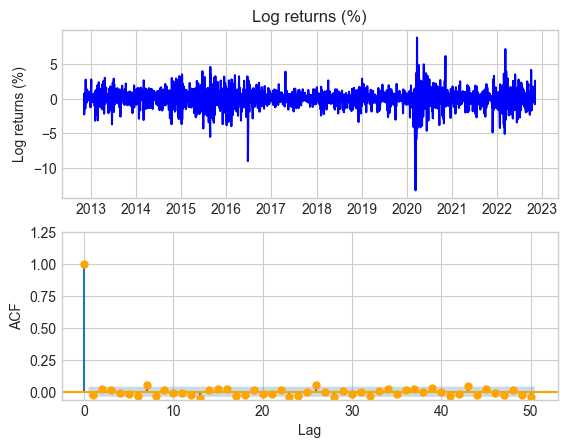

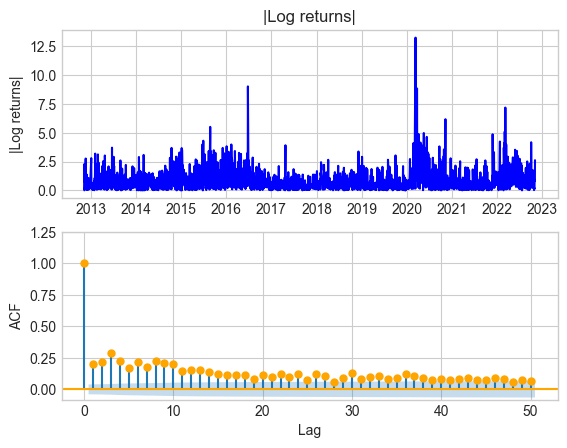

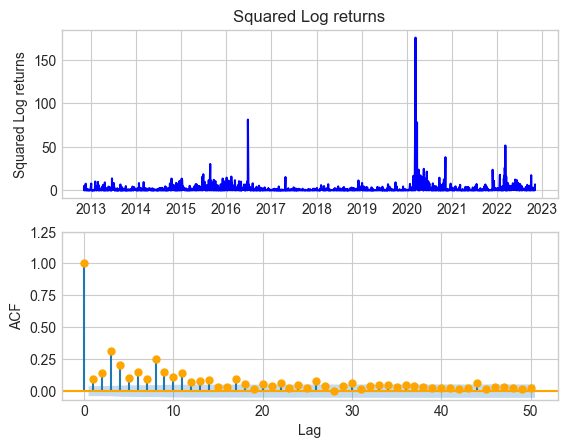

In [6]:
plot_acf_graphs(df['log_returns'].dropna(), 'Log returns (%)')
plt.savefig('./plots/q1/Q1B1.png')
plot_acf_graphs(np.abs(df['log_returns'].dropna()), '|Log returns|')
plt.savefig('./plots/q1/Q1B2.png')
plot_acf_graphs(df['log_returns'].dropna()**2, 'Squared Log returns')
plt.savefig('./plots/q1/Q1B3.png')


# A iii)

In [7]:
from scipy.stats.distributions import t

In [8]:
# make GARCH(1,1) model with normal innovations
model = arch_model(df['log_returns'].dropna(),
                 mean='Constant', 
                 vol='GARCH', 
                 p=1, q=1, rescale=True, dist='normal')

model_fit = model.fit(disp=0)
sum = model_fit.summary()
sum.as_latex()
sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3758.85
Distribution:                  Normal   AIC:                           7525.71
Method:            Maximum Likelihood   BIC:                           7549.02
                                        No. Observations:                 2509
Date:                Fri, Nov 25 2022   Df Residuals:                     2508
Time:                        12:34:31   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0590  2.093e-02      2.819  4.812e-03 [1.799e-02,  0.100]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0543  1.879e-02      2.892  3.831e-03 [1.751e-02,9.118e-02]
alpha[1]       0.1303  3.114e-02      4.184  2.861e-05   [6.927e-02,  0.191]
beta[1]        0.8364  3.552e-02     23.549 1.285e-122     [  0.767,  0.906]
============================================================================

Covariance estimator: robust
"""

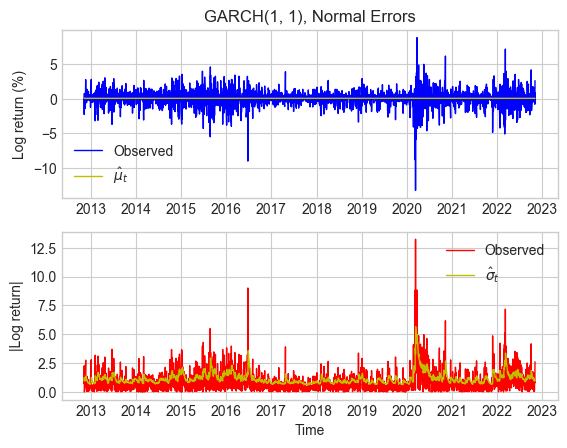

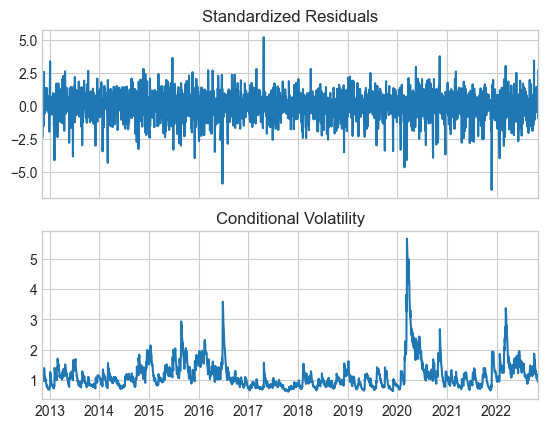

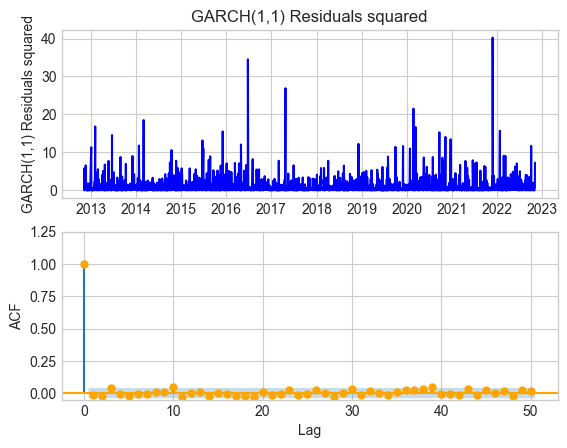

In [9]:
cv = pd.Series(model_fit.conditional_volatility, index=df['log_returns'].dropna().index)
mean = pd.Series(model_fit.params.mu, index=df['log_returns'].dropna().index)

fig, axs = plt.subplots(2,1)
ax1, ax2 = axs


ax2.plot(np.abs(df['log_returns'].dropna()), 'r-', linewidth=1, label='Observed');
ax2.plot(cv, 'y-', linewidth=1, label=r'$\hat{\sigma}_{t}$');
ax2.set_xlabel('Time')
ax2.set_ylabel('|Log return|')
ax2.legend(prop={'size': 10}); 


ax1.plot(df['log_returns'].dropna(), 'b-', linewidth=1, label='Observed')
ax1.plot(mean, 'y-', linewidth=1, label=r'$\hat{\mu}_{t}$');
ax1.set_title("GARCH(1, 1), Normal Errors")
ax1.set_ylabel('Log return (%)')
ax1.legend(prop={'size': 10}); 
plt.savefig('./plots/q1/Q1C1.png');

model_fit.plot(); 
plt.savefig('./plots/q1/Q1C2.png');

plt.show()
plot_acf_graphs(model_fit.std_resid**2, title='GARCH(1,1) Residuals squared')



## a iv)

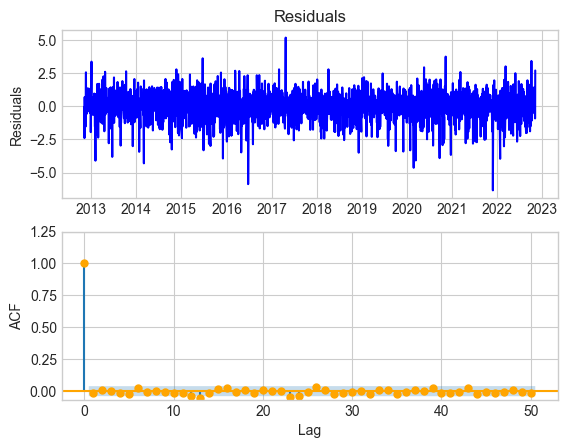

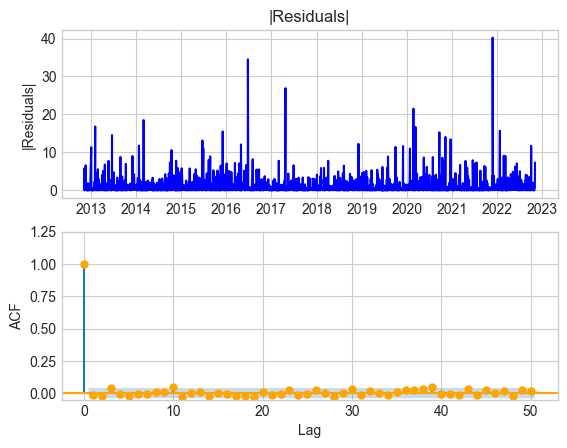

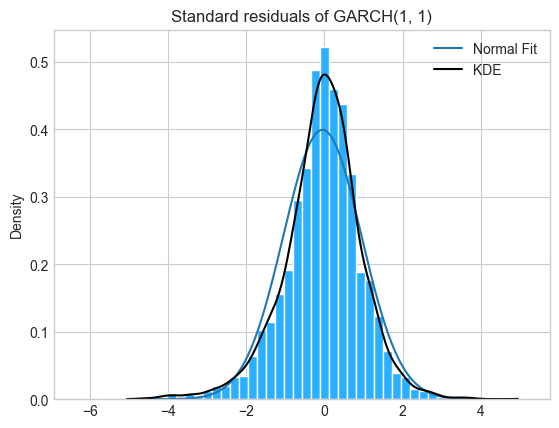

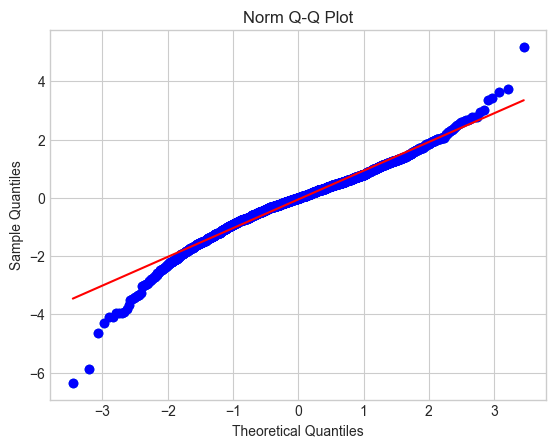

In [10]:
errors_std = np.std(model_fit.std_resid)
errors_mu = np.mean(model_fit.std_resid)


plot_acf_graphs(model_fit.std_resid, title='Residuals')
plt.savefig('plots/q1/Q1D1.png'); plt.show()
plot_acf_graphs(model_fit.std_resid**2, title='|Residuals|')
plt.savefig('plots/q1/Q1D2.png'); plt.show()

kde = ss.gaussian_kde(model_fit.std_resid)

x = np.linspace(errors_mu - 5*errors_std, errors_mu + 5*errors_std, 1001)

plt.plot(x, ss.norm.pdf(x, errors_mu, errors_std), label= 'Normal Fit');
plt.plot(x, kde(x), label='KDE', color='k');
plt.hist(model_fit.std_resid, bins=50, density=True,facecolor='#2ab0ff', edgecolor='white');
plt.ylabel('Density')
plt.title("Standard residuals of GARCH(1, 1)")

plt.legend()
plt.savefig('plots/q1/Q1D3.png'); plt.show()

qqplot(model_fit.std_resid)
plt.savefig('plots/q1/Q1D4.png')




## A v)

In [11]:
def arma11_garch11_t_loglikelihood(alpha0, alpha1, beta1, arma_mu, phi1, theta1, nu, x):

    var = np.zeros_like(x)
    mu = np.zeros_like(x) # for storing the time series of \mu_t

    # We need proxies for sigma_0^2, \mu_0 
    var[0] = np.var(x, ddof=1) # sample variance
    mu[0] = np.mean(x) # sample mean

    # Iteration over the ARMA(1,1)-GARCH(1,1) dynamics
    for i in range(1, len(x)):
        mu[i] = arma_mu + phi1 * (x[i-1] - arma_mu) + theta1 * (x[i-1] - mu[i-1])
        var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]

    return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))

# define objective functions and constrain
objfun_armagarch_t = lambda y : -1 * arma11_garch11_t_loglikelihood(y[0], y[1], y[2], y[3], y[4], y[5], y[6], df['log_returns'].dropna())
constraint = lambda y :  1 - y[1] - y[2]

# initialise values and bounds
y0 = [1, 0.1, 0.1, 0, 0, 0, 10]
bnds = ((0,np.inf), (0,1), (0,1), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf))
con = {'type': 'ineq', 'fun': constraint} 


# minimise
sol_loglikelihood = minimize(objfun_armagarch_t,y0,method='SLSQP',bounds=bnds,constraints=con, options={'disp': True})

print("Estimate of alpha0: " + str(sol_loglikelihood.x[0]))
print("Estimate of alpha1: " + str(sol_loglikelihood.x[1]))
print("Estimate of beta1: " + str(sol_loglikelihood.x[2]))
print("Estimate of mu: " + str(sol_loglikelihood.x[3]))
print("Estimate of phi1: " + str(sol_loglikelihood.x[4]))
print("Estimate of theta1: " + str(sol_loglikelihood.x[5]))
print("Estimate of nu: " + str(sol_loglikelihood.x[6]))
print("Solution->",sol_loglikelihood)

C:\Users\George\AppData\Local\Temp\ipykernel_20644\1193735620.py:13: RuntimeWarning: overflow encountered in double_scalars
  var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]
C:\Users\George\AppData\Local\Temp\ipykernel_20644\1193735620.py:12: RuntimeWarning: overflow encountered in double_scalars
  mu[i] = arma_mu + phi1 * (x[i-1] - arma_mu) + theta1 * (x[i-1] - mu[i-1])
C:\Users\George\AppData\Local\Temp\ipykernel_20644\1193735620.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))
C:\Users\George\AppData\Local\Temp\ipykernel_20644\1193735620.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))
C:\Users\George\AppData\Local\Temp\ipykernel_20644\1193735620.py:13: RuntimeWarning: invalid value encountered in double_scalars


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3651.780443740955
            Iterations: 41
            Function evaluations: 373
            Gradient evaluations: 40
Estimate of alpha0: 0.04164372341194103
Estimate of alpha1: 0.1400288549922945
Estimate of beta1: 0.8442962245050765
Estimate of mu: 0.0738284827011157
Estimate of phi1: 0.9309395148449009
Estimate of theta1: -0.9533352783001889
Estimate of nu: 4.779162376307801
Solution->      fun: 3651.780443740955
     jac: array([ 0.1217041 ,  0.01257324,  0.0489502 , -0.01412964, -0.06521606,
       -0.08630371,  0.00137329])
 message: 'Optimization terminated successfully'
    nfev: 373
     nit: 41
    njev: 40
  status: 0
 success: True
       x: array([ 0.04164372,  0.14002885,  0.84429622,  0.07382848,  0.93093951,
       -0.95333528,  4.77916238])


In [12]:
# create var and mu series 

var = np.zeros_like(df['log_returns'].dropna())
mu = np.zeros_like(df['log_returns'].dropna()) # for storing the time series of \mu_t

# We need proxies for sigma_0^2, \mu_0 
var[0] = np.var(df['log_returns'].dropna(), ddof=1) # sample variance
mu[0] = np.mean(df['log_returns'].dropna()) # sample mean

# Iteration over the ARMA(1,1)-GARCH(1,1) dynamics
for i in range(1, len(df['log_returns'].dropna())):
    mu[i] = sol_loglikelihood.x[3] + (sol_loglikelihood.x[4])* (df['log_returns'].dropna()[i-1] - sol_loglikelihood.x[3]) + (sol_loglikelihood.x[5]) * (df['log_returns'].dropna()[i-1] - mu[i-1])
    var[i] = (sol_loglikelihood.x[0]) + (sol_loglikelihood.x[1]) * (df['log_returns'].dropna()[i-1] - mu[i-1])**2 + (sol_loglikelihood.x[2]) * var[i-1]


In [13]:
mu = pd.Series(mu, index=df['log_returns'].dropna().index)
std = pd.Series(np.sqrt(var), index=df['log_returns'].dropna().index)
std_residuals = (df['log_returns'].dropna() - mu)/np.sqrt(var)

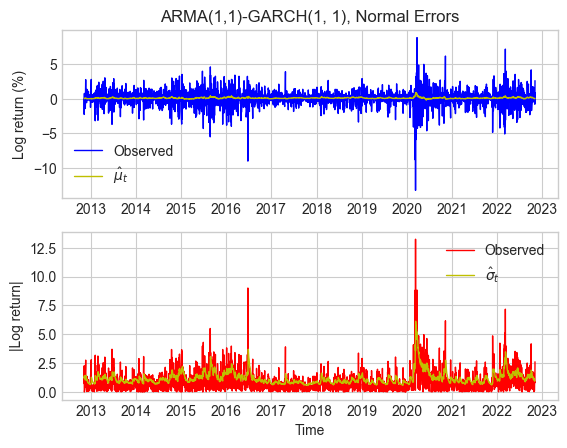

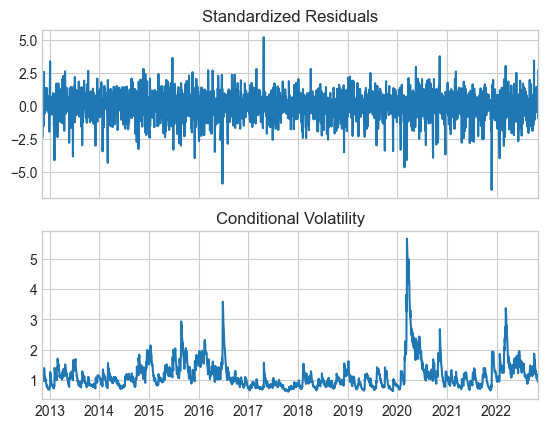

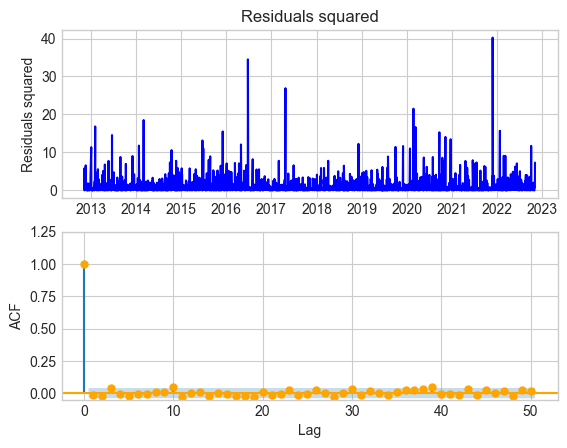

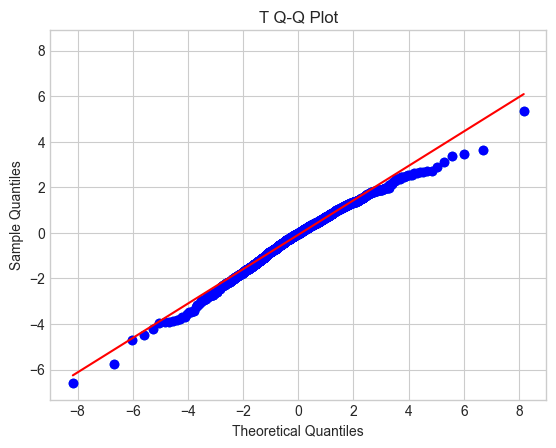

In [16]:
fig, axs = plt.subplots(2,1)
ax1, ax2 = axs


ax2.plot(np.abs(df['log_returns'].dropna()), 'r-', linewidth=1, label='Observed');
ax2.plot(std, 'y-', linewidth=1, label=r'$\hat{\sigma}_{t}$');
ax2.set_xlabel('Time')
ax2.set_ylabel('|Log return|')
ax2.legend(prop={'size': 10}); 


ax1.plot(df['log_returns'].dropna(), 'b-', linewidth=1, label='Observed')
ax1.plot(mu, 'y-', linewidth=1, label=r'$\hat{\mu}_{t}$');
ax1.set_title("ARMA(1,1)-GARCH(1, 1), Normal Errors")
ax1.set_ylabel('Log return (%)')
ax1.legend(prop={'size': 10}); 
plt.savefig('./plots/q1/Q1E1.png');

model_fit.plot(); 
plt.savefig('./plots/q1/Q1E2.png');

plt.show()
plot_acf_graphs(model_fit.std_resid**2, title='Residuals squared')
plt.savefig('./plots/q1/Q1E3.png');

qqplot(std_residuals, dist=t(df=sol_loglikelihood.x[6]))
plt.savefig('./plots/q1/Q1E4.png')